In [1]:
# -*- coding: UTF-8 -*-
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import pymongo
import pandas as pd 
import numpy as np
import pickle


from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from konlpy.tag import Twitter
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from scipy.sparse import vstack

from sklearn.metrics import accuracy_score

<h3>Predict Train Data</h3>

In [2]:
df_2 = pd.read_excel("mnet_music777.xlsx")

In [3]:
df_2.columns

Index(['순위', '곡명', '가수', '작곡', '작사', '피쳐링', '년월', '발매일', '음악장르', '재생시간', '좋아요',
       '편곡', '활동유형', '작곡1', '작곡2', '작곡3', '작곡4', '작곡5', '작곡6', '작곡7', '작곡8',
       '작곡9', '작곡10', '작곡11', '작곡12', '작사1', '작사2', '작사3', '작사4', '작사5', '작사6',
       '작사7', '작사8', '작사9', '작사10', '작사11', '작사12', '가수1', '가수2', '가수3', '가수4',
       '가수5', '가수6', '가수7', '가수8', '가수9', '가수10', '가수11'],
      dtype='object')

In [4]:
df_2.head(2)

,순위,곡명,가수,작곡,작사,피쳐링,년월,발매일,음악장르,재생시간,...,가수2,가수3,가수4,가수5,가수6,가수7,가수8,가수9,가수10,가수11
0,1위,Gee,소녀시대,이트라이브,이트라이브,없음,2009,2009.01.05,댄스 > 댄스,03:22,...,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음
1,2위,이젠 남이야 (Feat. Baby-J of Jewelry),김경록,조영수,조영수,Baby-J,2009,2008.12.16,가요 > 알앤비,04:07,...,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음


In [5]:
df_2['순위_2'] = df_2['순위'].apply(lambda x: float(x[:-1]))
df_2['순위_4'] = df_2['순위_2'].apply(lambda x : True if x <= 10 else False) #(df_2['순위_2']-1)/10

In [6]:
# 작곡, 가수의 공백 제거
df_2['가수1_rb'] = df_2['가수1'].apply(lambda x: str(x).replace(" ", ""))
df_2['작곡1_rb'] = df_2['작곡1'].apply(lambda x: str(x).replace(" ", ""))

<h3>음악장르 처리</h3>

In [7]:
# OST          268
# 가요 > 락      1080
# 가요 > 알앤비    9359
# 가요 > 힙합     3076
# 기타           970
# 댄스 > 댄스     6818

In [8]:
df_2.groupby('음악장르').size()

음악장르
OST          188
가요 > 락       656
가요 > 알앤비    5319
가요 > 힙합     1804
기타           538
댄스 > 댄스     3474
dtype: int64

In [9]:
def trans_music_type(x):
    if str(x) == 'OST':
        return 0
    if str(x) == '가요 > 락':
        return 1
    if str(x) == '가요 > 알앤비':
        return 2
    if str(x) == '가요 > 힙합':
        return 3
    if str(x) == '기타':
        return 4
    if str(x) == '댄스 > 댄스':
        return 5
    else:
        return 6

In [10]:
df_2['음악장르_2'] = df_2['음악장르'].apply(trans_music_type)

In [11]:
import seaborn as sns
sns.countplot(df_2['순위_4'])

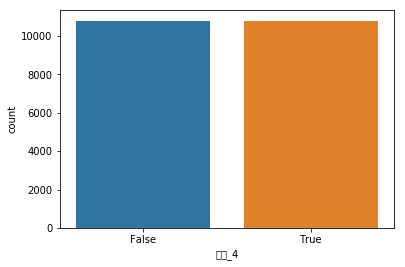

In [12]:
#class 분포가 너무 치우쳐져 있다. => false라고만 대답하면 90프로는 맞는다.. 
# 분포를 맞추기 위해 복사함 10위 안 데이터를 
import seaborn as sns
train_top_10 = df_2[df_2['순위_2'] <= 10]

for i in range(8):
    df_2 = pd.concat([df_2, train_top_10])
    
sns.countplot(df_2['순위_4'])

In [13]:
# train test 나누기

# random idx 뽑기
test_idx = np.random.choice(len(df_2), 5000, replace=False)
train_idx = list({i for i in range(len(df_2))} - set(test_idx))

train = df_2.iloc[train_idx]
test = df_2.iloc[test_idx]

In [14]:
print(len(train))
print(len(test))

16571
5000


장르 처리

In [15]:
# 장르 vectorize

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

music_type = np.array(train['음악장르_2']).reshape(-1,1)

ohe.fit(music_type)
t_music_type = ohe.transform(music_type).toarray()

t_music_type

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

작곡, 가수 처리

In [16]:
# 작곡, 가수 vectorize
vectorizer_singer =  TfidfVectorizer(ngram_range=(1,1))
vectorizer_pd =  TfidfVectorizer(ngram_range=(1,1))

singer_vec = vectorizer_singer.fit_transform(train['가수1_rb'])
pd_vec = vectorizer_pd.fit_transform(train['작곡1_rb'])

In [17]:
# 가수 , 작곡 각각 feature 수(사전)
print(len(vectorizer_singer.get_feature_names()))
print(len(vectorizer_pd.get_feature_names()))

894
1107


In [18]:
# 두 sparse matrix(가수, 작곡) 합치기
from scipy import sparse
singer_pd_vec = hstack((singer_vec, pd_vec))
singer_pd_vec

<16571x2001 sparse matrix of type '<class 'numpy.float64'>'
	with 32905 stored elements in COOrdinate format>

In [19]:
# 장르 합치기
singer_pd_type_vec = hstack((singer_pd_vec, np.array(train['음악장르_2']).reshape(-1,1)))

In [20]:
train_x = singer_pd_type_vec
train_y = train['순위_4']

In [21]:
# model_rf = RandomForestClassifier(n_estimators=500, max_depth=10).fit(train_x, train_y)

In [22]:
from sklearn.linear_model import SGDClassifier
model_rf = LogisticRegression().fit(train_x, train_y)

In [23]:
pred_train = model_rf.predict(train_x)
accuracy_score(train['순위_4'], pred_train)

0.7403898376682155

In [24]:
from sklearn.metrics import classification_report
print(classification_report(train_y, pred_train))

             precision    recall  f1-score   support

      False       0.80      0.63      0.71      8228
       True       0.70      0.85      0.77      8343

avg / total       0.75      0.74      0.74     16571



<h3>2. Predict Test data  </h3>

In [25]:
# train vectorizer 활용 tfidf 
feature_list_singer = vectorizer_singer.get_feature_names()
feature_list_pd = vectorizer_pd.get_feature_names()

In [26]:
test_vectorizer_singer =  TfidfVectorizer(ngram_range=(1,1), vocabulary = feature_list_singer)
test_vectorizer_pd =  TfidfVectorizer(ngram_range=(1,1), vocabulary = feature_list_pd)

In [27]:

test_vec_singer = test_vectorizer_singer.fit_transform(test['가수1_rb'])
test_vec_pd = test_vectorizer_pd.fit_transform(test['작곡1_rb'])


In [34]:
test_vec_pd_singer = hstack((test_vec_singer, test_vec_pd))
test_y = test['순위_4']
test_x = hstack((test_vec_pd_singer, np.array(test['음악장르_2']).reshape(-1,1)))

In [35]:
print(train_x.shape)
print(test_x.shape)

(16571, 2002)
(5000, 2002)


In [36]:
pred_test = model_rf.predict(test_x)
accuracy_score(test_y, pred_test)

0.71

In [37]:
print(classification_report(test['순위_4'], pred_test))

             precision    recall  f1-score   support

      False       0.78      0.60      0.68      2552
       True       0.66      0.83      0.74      2448

avg / total       0.72      0.71      0.71      5000



In [38]:
#model_rf.feature_importances_[model_rf.feature_importances_ >= 0.02]

In [39]:
test_vectorizer_singer.get_feature_names()

['10cm',
 '15',
 '2am',
 '2ne1',
 '2pm',
 '45rpm',
 '7goup',
 'ab에비뉴',
 'adamlevine',
 'adele',
 'aj',
 'alanwalker',
 'albertkick',
 'aliciakeys',
 'andraday',
 'aoa',
 'aoablack',
 'aoacream',
 'apink',
 'arianagrande',
 'ashily',
 'avrillavigne',
 'b1a4',
 'beyonce',
 'bizzy',
 'blackeyedpeas',
 'blackpink',
 'bmk',
 'bobby',
 'britneyspears',
 'bro',
 'brunomars',
 'camilacabello',
 'carlabruni',
 'carlyraejepsen',
 'charlieputh',
 'cherryfilter',
 'christinaaguilera',
 'ciara',
 'cl',
 'clown',
 'coogie',
 'craigdavid',
 'crush',
 'cthemax',
 'davidguetta',
 'dean',
 'demilovato',
 'djdoc',
 'djgollum',
 'djkuba',
 'dk',
 'dmtn',
 'drake',
 'duffy',
 'edsheeran',
 'elliegoulding',
 'eminem',
 'emmastone',
 'exid',
 'exo',
 'fareastmovement',
 'fitz',
 'florida',
 'flowsik',
 'ftisland',
 'gg',
 'god',
 'ham',
 'hisuhyun',
 'homme',
 'iconapop',
 'idinamenzel',
 'ikon',
 'illionairerecords',
 'imaginedragons',
 'jamezz',
 'jasonmraz',
 'jbj',
 'jbj95',
 'jeffbernat',
 'jessiej',
 '

In [40]:
# sum(model_rf.feature_importances_ >= 0.017)

# import_features_idx = np.where(model_rf.feature_importances_ >= 0.017)

# import_features_idx

# print(len(vectorizer_singer.get_feature_names()))
# print(len(vectorizer_pd.get_feature_names()))

# np.array(vectorizer_singer.get_feature_names())[[,  349,  516]]


# np.array(vectorizer_pd.get_feature_names())[[1237-902, 1339-902, 1539-902, 1615-902, 1653-902]]

<h3>3. Predict User Input Data </h3>

In [124]:
singer = '종찬'
producer = '지드래곤'
user_music_type = '가요 > 알앤비'

In [125]:
singer = str(singer).replace(" ", "")
producer = str(producer).replace(" ", "")
user_music_type = trans_music_type(user_music_type)

In [126]:
user_x = {"가수":[singer], "작곡": [producer], "장르":[user_music_type]}

In [127]:
user_x = pd.DataFrame(user_x, columns=["가수","작곡","장르"])

In [128]:
feature_list_singer = vectorizer_singer.get_feature_names()
feature_list_pd = vectorizer_pd.get_feature_names()

user_vectorizer_singer =  TfidfVectorizer(ngram_range=(1,1), vocabulary = feature_list_singer)
user_vectorizer_pd =  TfidfVectorizer(ngram_range=(1,1), vocabulary = feature_list_pd)

In [129]:
user_vec_singer = user_vectorizer_singer.fit_transform(user_x['가수'])
user_vec_pd = user_vectorizer_pd.fit_transform(user_x['작곡'])
user_vec_singer_pd = hstack((user_vec_singer, user_vec_pd))

In [130]:
user_x_2 = hstack((user_vec_singer_pd, user_x['장르']))



In [131]:
pred_user = model_rf.predict(user_x_2)

In [132]:
print(pred_user[0])

False


In [133]:
model_rf.predict_proba(user_x_2)

array([[0.50247977, 0.49752023]])

<h3>4. Pickle 활용</h3>

In [50]:
len(feature_list_singer)
len(feature_list_pd)

1107

In [51]:
import pickle

with open('feature_list_singer_2.txt','wb') as f:
    pickle.dump(feature_list_singer,f)

with open('feature_list_pd_2.txt', 'wb') as f:
    pickle.dump(feature_list_pd, f)

In [52]:
with open('final_model', 'wb') as f:
    pickle.dump(model_rf, f)

In [53]:
with open('final_model','rb') as f:
    final_model = pickle.load(f)   

In [54]:
final_model.predict(user_x_2)

array([False])

In [55]:
with open('feature_list_singer_2.txt','rb') as f:
    feature_list_singer_2=pickle.load(f)   
    
with open('feature_list_pd_2.txt','rb') as f:
    feature_list_pd_2=pickle.load(f)         

In [56]:
singer = '홍다희'
producer = '이대환'

In [57]:
singer = str(singer).replace(" ", "")
producer = str(producer).replace(" ", "")

user_x = {"가수":[singer], "작곡": [producer]}
user_x = pd.DataFrame(user_x, columns=["가수","작곡"])

feature_list_singer = vectorizer_singer.get_feature_names()
feature_list_pd = vectorizer_pd.get_feature_names()

user_vectorizer_singer =  TfidfVectorizer(ngram_range=(1,1), vocabulary = feature_list_singer_2)
user_vectorizer_pd =  TfidfVectorizer(ngram_range=(1,1), vocabulary = feature_list_pd_2)



user_vec_singer = user_vectorizer_singer.fit_transform(user_x['가수'])
user_vec_pd = user_vectorizer_pd.fit_transform(user_x['작곡'])
user_x = hstack((user_vec_singer, user_vec_pd))

# 

pred_user = model_rf.predict(user_x)
print(pred_user[0])

ValueError: X has 2001 features per sample; expecting 2002

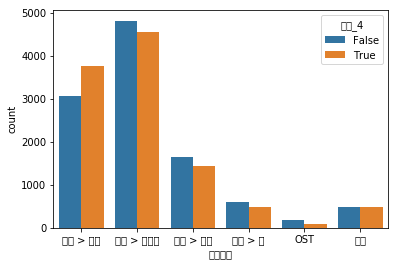

In [58]:
sns.countplot(df_2['음악장르'], hue=df_2['순위_4'])

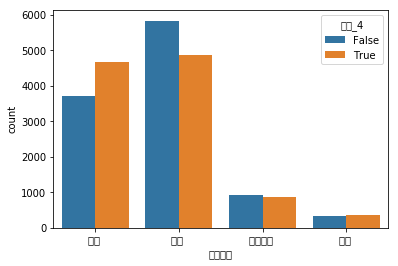

In [59]:
sns.countplot(df_2['활동유형'], hue=df_2['순위_4'])

In [62]:
df_2.groupby('음악장르').size()

음악장르
OST          268
가요 > 락      1080
가요 > 알앤비    9359
가요 > 힙합     3076
기타           970
댄스 > 댄스     6818
dtype: int64